# Capacitação Vialab  # Atividade 9

## Redução de dimensionalidade
### Data de atualização: 08/02/2022

# Objetivo: Enter o funcionamento e conceitos básicos sobre redução de dimensionalidade 

## Redução de dimensionalidade

A redução da dimensionalidade é a transformação de dados de alta dimensão em uma representação significativa da dimensionalidade reduzida. Idealmente, a representação reduzida deve ter uma dimensionalidade que corresponda à dimensionalidade intrínseca dos dados.

A dimensionalidade intrínseca dos dados é o número mínimo de parâmetros necessários para explicar as propriedades observadas dos dados.


### Principal Components Analysis (PCA)

A análise por componentes principais, do inglês Principal Component Analysis (PCA), acha um novo conjunto de dimensões tal que todas as dimensões são ortogonais (e consequentemente linearmente independente) e são elencadas de acordo com a variância dos dados ao longo destas dimensões. Isso significa que os eixos principais onde há maior variância, i.e., maior espalhamento de dados, ocorrem primeiro.

#### Funcionamento do PCA


1. Calcule a matriz de covariância $X$ de todos os pontos.
2. Calcule os autovetores e seus correspondentes autovalores.
3. Ordene os autovetores de acordo com seus autovalores em ordem decrescente.
4. Escolha os primeiro $k$ autovalores e eles serão as novas $k$ dimensões.
5. Transforme os $n$ pontos originais em $k$ dimensões.

<img src="https://pic1.zhimg.com/v2-5c6680eca5949615992c87b36040481c_1440w.gif?source=172ae18b"/>

In [ ]:
from sklearn.datasets import load_iris
from IPython.display import Markdown
import warnings
warnings.filterwarnings('ignore')

iris = load_iris()

print('Number of instances:', iris.data.shape[0])
print('Number of attributes', iris.data.shape[1])

In [ ]:
# import pandas as pd
import numpy as np

columns = list(iris.feature_names) + ['target']
df_iris = pd.DataFrame(np.concatenate([iris.data, 
                                       np.expand_dims(iris.target, axis=1)], axis=1), columns=columns)

df_iris['target'] = df_iris['target'].astype(int)
df_iris['target'] = df_iris['target'].apply(lambda x: iris.target_names[x])

df_iris

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(df_iris, hue='target', markers=["o", "s", "D"])
plt.show()

In [ ]:
from sklearn.decomposition import PCA

n_components = 2
components_columns = ['C%d' % i for i in range(1, n_components+1)]

pca = PCA(n_components=n_components)
X = df_iris[iris.feature_names].values

components = pca.fit_transform(X)

df_PCA = pd.DataFrame(components, columns=components_columns)
df_PCA['target'] = df_iris['target'].copy()

df_PCA

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

pca_reconstructed = pca.inverse_transform(df_PCA[components_columns])
MSE = mean_squared_error(X, pca_reconstructed)
MAE = mean_absolute_error(X, pca_reconstructed)
variance = pca.explained_variance_ratio_.sum()


Markdown("""
<center>
<b>PCA</b>

|  Métrica  |  Valor |
|:----------|:------:|
|    MSE    |  %.2f  |
|    MAE    |  %.2f  |
| Variância |  %.2f  |

</center>
""" % (MSE, MAE, variance))

In [ ]:
sns.scatterplot(data=df_PCA, x='C1', y='C2', hue='target')
plt.show()

In [ ]:
sns.jointplot(data=df_PCA, x='C1', y='C2', kind = 'kde')
plt.show()

### Autoencoder (AE)

"Autoencoding" é um algoritmo para compressão de dados onde a compressão e decompressão de dados são 1) especifico a um tipo de dado, 2) possui perda e 3) aprende automaticamente através de exemplos. Praticamente todos os contextos que tratam da implementação de autoencoders consideram-na utilizando-se redes neurais.

Um Autoencoder necessita de três coisas:
1. Uma função de encoding (codificação)
2. Uma função de decoding (decodificação)
3. Uma função de distância que mede a quantidade de informação perdida entre a representação comprimida e a reconstruída de seu dado


Um autoencoder pode ser usado para gerar uma versão comprimidada de uma imagem, por exemplo, mas outras duas aplicações têm sido na remoção de ruídos de dados (data denoising) e redução de dimensionalidade. No contexto do último caso, o Autoencoder atua como uma generalização do Principal Component Analysis (PCA), onde a saída da função de encoding indica em quantas componentes a dimensão será reduzida.

A versão comprimida do dado original, isto é, a saída do encoder, possui uma representação discreta, ou seja, assumem um único valor para a mesma amostra de dados, conforme a imagem abaixo.

Leitura complementar: https://blog.keras.io/building-autoencoders-in-keras.html

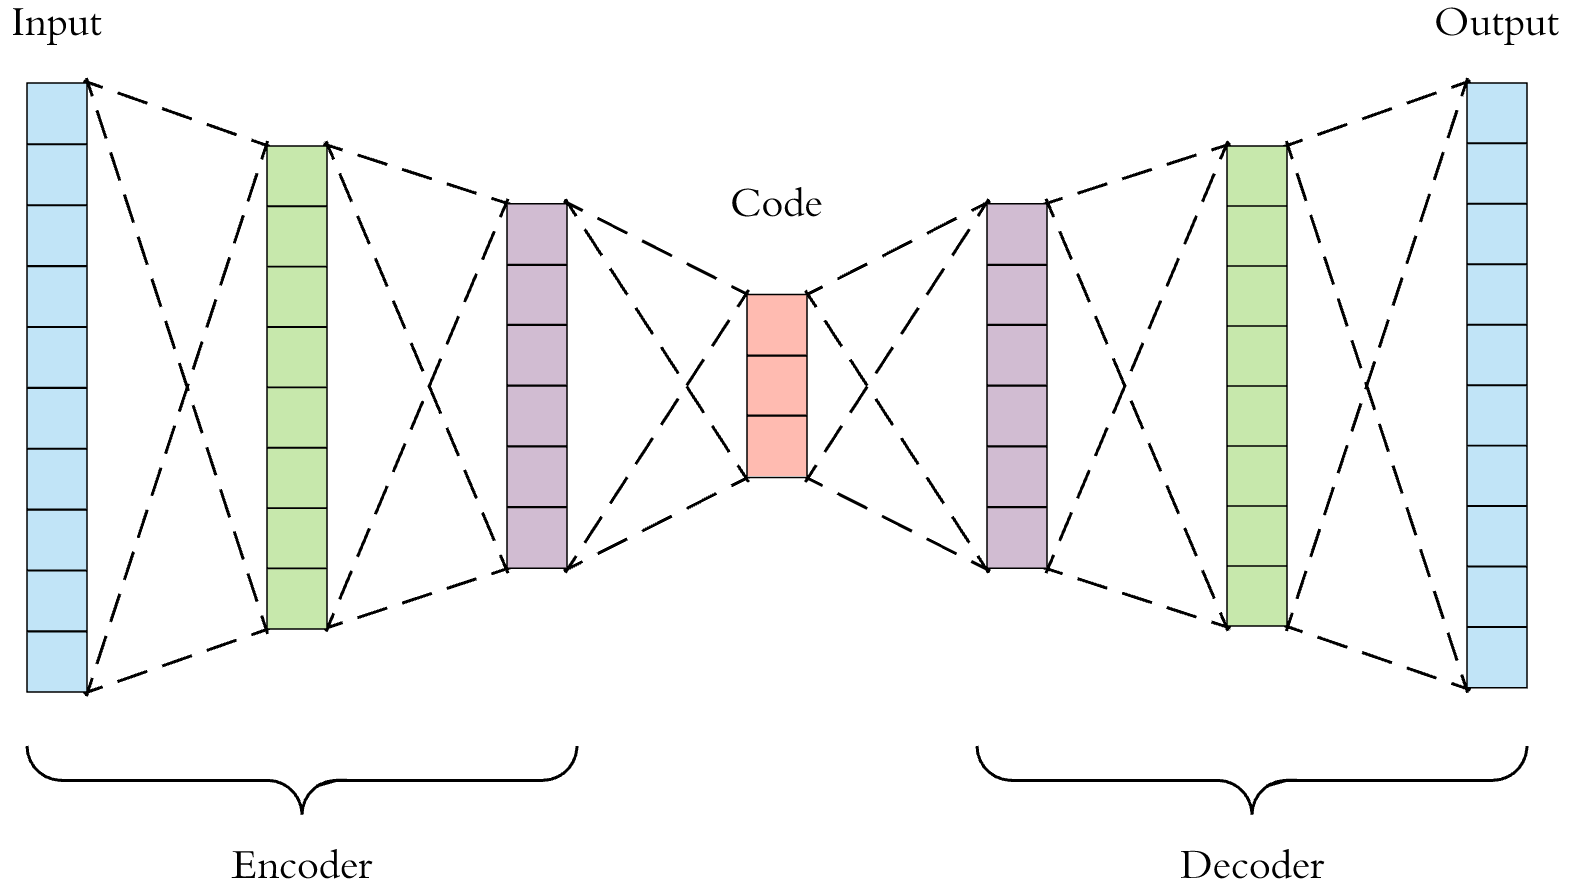

A imagem abaixo mostra alguns exemplos do dataset MNIST fornecidos a um Autoencoder. A primeira linha possui as imagens originais dos números, já a segunda linha contém a imagem reconstruída (saída da função de decoder). Neste caso, é possível notar que a versão reconstruída das imagens possui uma leve perda de qualidade quando comparada com a original.

<img src="https://blog.keras.io/img/ae/basic_ae_32.png" />

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

encoder_input = Input(shape=(len(iris.feature_names),))
x = Dense(units=n_components) (encoder_input)
x = PReLU() (x)

encoder = Model(encoder_input, x, name='encoder')
encoder.summary()

In [ ]:
decoder_input = Input(shape=(n_components,))
x = Dense(units=len(iris.feature_names)) (decoder_input)
x = PReLU() (x)

decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

In [ ]:
outputs = decoder(encoder(encoder_input))
ae = Model(encoder_input, outputs, name='autoencoder')
ae.compile(loss='mse', metrics=['mae'], optimizer='adam')
ae.summary()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
y = iris.target

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_idx, test_idx = next(sss.split(X,y))

x_train = X[train_idx]
x_test = X[test_idx]

In [ ]:
history = ae.fit(
    x=x_train,
    y=x_train,
    batch_size=6,
    epochs=200,
    validation_split=0.3,
    verbose=0
)

In [ ]:
fig, ax = plt.subplots(ncols=len(ae.metrics_names), figsize=(12,5))

for i, metric in enumerate(ae.metrics_names):
    ax[i].plot(history.history[metric], label=metric, c='r')
    ax[i].plot(history.history['val_'+metric], label='val_'+metric, c='k')
    ax[i].legend()
    
plt.show()

In [ ]:
evals = ae.evaluate(x_test, x_test, verbose=0)
    
Markdown("""
<center>
<b>Autoencoder</b>

|  Métrica  |  Valor |
|:----------|:------:|
|    MSE    |  %.2f  |
|    MAE    |  %.2f  |

</center>
""" % (evals[0], evals[1]))

In [ ]:
components_AE = encoder.predict(X)

df_AE = pd.DataFrame(components_AE, columns=components_columns)
df_AE['target'] = df_iris['target'].copy()

df_AE

In [ ]:
sns.scatterplot(data=df_AE, x='C1', y='C2', hue='target')
plt.show()

In [ ]:
sns.jointplot(data=df_AE, x='C1', y='C2', kind = 'kde')
plt.show()

### Variational Autoencoder (VAE)

Fonte: https://www.jeremyjordan.me/variational-autoencoders/ e https://wiseodd.github.io/techblog/2016/12/17/conditional-vae/

Um autoencoder variacional (VAE) provê uma maneira probabilística para descrever observações em um espaço latente. Assim, em vez de construir um codificador (encoder) que produz uma única saída para descrever cada atributo do espaço latente, o encoder formulado para o VAE descreve uma distribuição probabilística para cada um destes atributos.

#### Espaço latente

O espaço latente é uma região que contém os atributos comprensados que descrevem a imagem de entrada. Os atributos latentes, isto é, os atributos que pertencem ao espaço latente da imagem são aprendidos e descritos pela seção de encoder de um autoencoder.

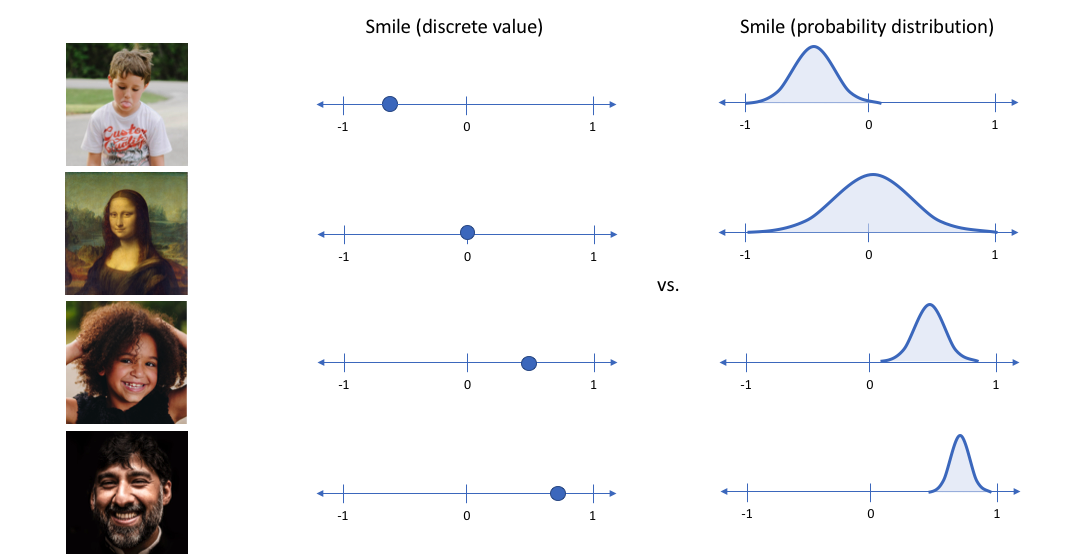

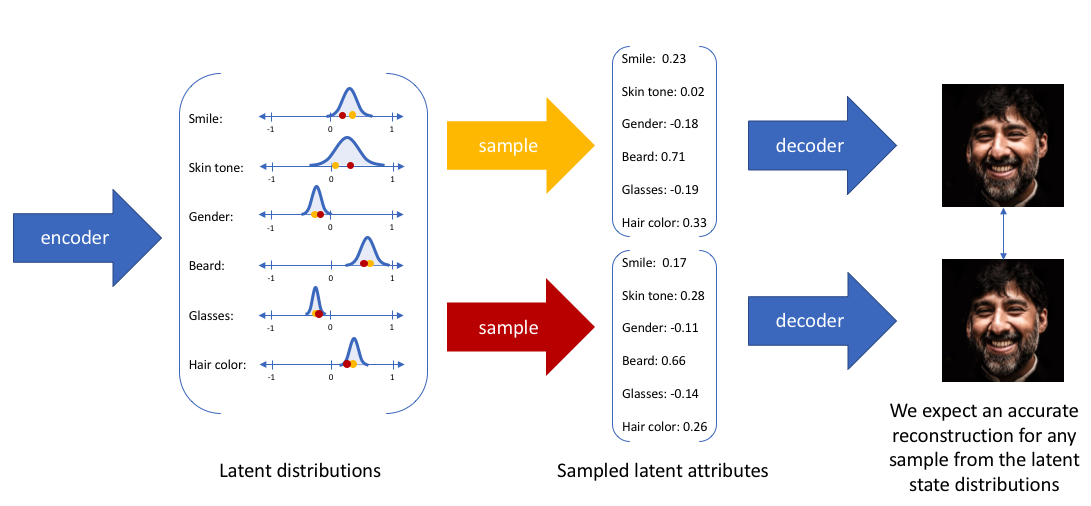

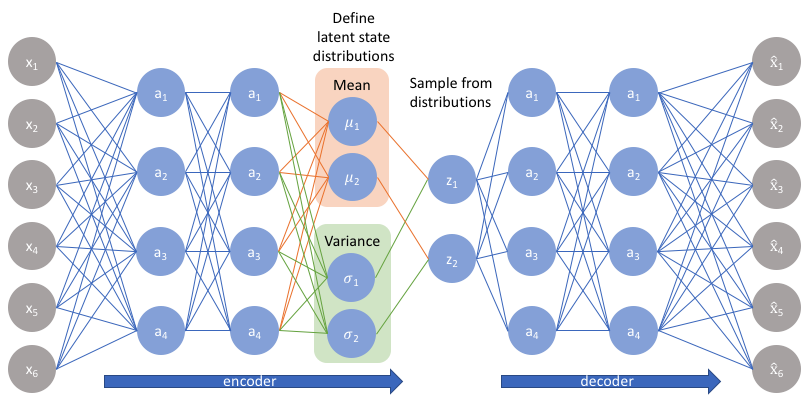

No entanto, esse processo de amostragem requer alguma atenção extra. Ao treinar o modelo, precisamos ser capazes de calcular o relacionamento de cada parâmetro na rede com relação à perda final de saída usando uma técnica conhecida como retropropagação de erro. No entanto, simplesmente não podemos fazer isso para um processo de amostragem aleatória. Felizmente, podemos aproveitar uma ideia inteligente conhecida como "truque de reparameterização".

## O truque de reparametrização

Ele sugere que amostremos $ε$ aleatoriamente a partir de uma unidade gaussiana e depois alteremos o $ε$ amostrado aleatoriamente pela média da distribuição latente $μ$ e escaloná-lo pela variação da distribuição latente $σ$.

Assim, precisamos do truque de reparametrização para retropropagar através de um nó aleatório.

Intuitivamente, em sua forma original, os VAEs amostram a partir de um nó aleatório $z$, que é aproximado pelo modelo paramétrico $q$ ($z$∣$ϕ$, $x$). O backprop não pode fluir através de um nó aleatório (baseado em probabilidade). 

A introdução de um novo parâmetro $ϵ$ permite reparar $z$ de uma maneira que permita que o backprop flua através dos nós determinísticos.

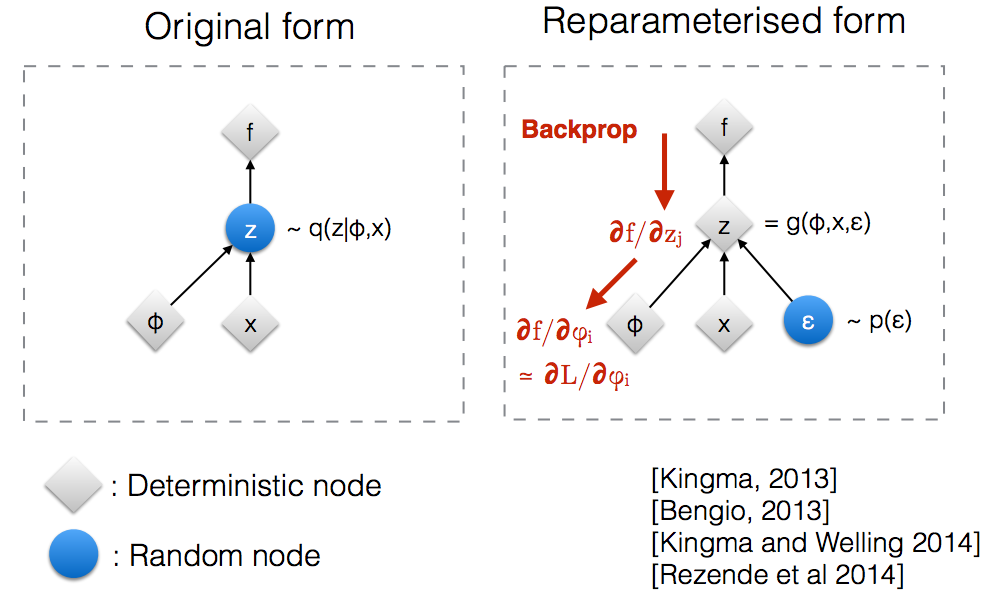

Para lidar com o fato de que a rede pode aprender valores negativos para $σ$, normalmente fazemos com que a rede aprenda o log $σ$ e exponencie esse valor para obter a variação da distribuição latente.

In [ ]:
from tensorflow.keras import backend as K

# reparametrization trick
def sampling(args):
    z_mean, z_log_var = args
    
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    epsilon = K.random_normal(shape=(batch, dim))
    
    s = K.exp(0.5 * z_log_var)
    
    return z_mean + s * epsilon

In [ ]:
latent_dimension = n_components

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

encoder_input = Input(shape=(len(iris.feature_names),))

x = Dense(units=len(iris.feature_names)) (encoder_input)
x = ReLU() (x)

z_mean = Dense(units=latent_dimension, name="z_mean") (x)
z_log_var = Dense(units=latent_dimension, name="z_log_var") (x)

z = Lambda(sampling, name="z")([z_mean, z_log_var])


encoder = Model(encoder_input, z, name='encoder')
encoder.summary()

In [ ]:
decoder_input = Input(shape=(latent_dimension,))
x = Dense(units=len(iris.feature_names)) (decoder_input)
x = PReLU() (x)

decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

In [ ]:
outputs = decoder(encoder(encoder_input))
vae = Model(encoder_input, outputs, name='variational_autoencoder')
vae.compile(loss='mse', metrics=['mae'], optimizer='adam')
vae.summary()

In [ ]:
history = vae.fit(
    x=x_train,
    y=x_train,
    batch_size=6,
    epochs=200,
    validation_split=0.3,
    verbose=0
)

In [ ]:
fig, ax = plt.subplots(ncols=len(vae.metrics_names), figsize=(12,5))

for i, metric in enumerate(vae.metrics_names):
    ax[i].plot(history.history[metric], label=metric, c='r')
    ax[i].plot(history.history['val_'+metric], label='val_'+metric, c='k')
    ax[i].legend()
    
plt.show()

In [ ]:
evals = vae.evaluate(x_test, x_test, verbose=0)
    
Markdown("""Variational Autoencoder

|  Métrica  |  Valor |
|:----------|:------:|
|    MSE    |  %.2f  |
|    MAE    |  %.2f  |

</center>
""" % (evals[0], evals[1]))

In [ ]:
components_VAE = encoder.predict(X)

df_VAE = pd.DataFrame(components_VAE, columns=components_columns)
df_VAE['target'] = df_iris['target'].copy()

df_VAE

In [ ]:
sns.scatterplot(data=df_VAE, x='C1', y='C2', hue='target')
plt.show()

In [ ]:
sns.jointplot(data=df_VAE, x='C1', y='C2', kind = 'kde')
plt.show()

###Exercício

CIFAR10 é dataset de 50.000 imagens coloridas de treinamento com resolução de 32x32 e 10.000 imagens de teste, rotuladas em 10 categorias.

Agora, a partir dos conhecimentos adquiridos até o momento, realizem a redução de dimensionalidade do dataset CIFAR10, comparando as técnicas e seus resultados. Após a redução, implementem uma rede neural para a classificação utilizando cada conjunto de dados(Normal, PCA, AE e VAE).

Como sempre, escrevam com capricho o trabalho, apresentem a análise exploratória, fundamentação, metodologia, resultados, discussões e conclusões, avaliando qualitativa e quantitativamente o desempenho do modelo gerado, utilizando todos os conceitos e métodos até aqui aprendidos.

Referência: https://keras.io/api/datasets/cifar10/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler,normalize
import pandas as pd


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

import numpy as np
EPOCHS =50
training = True


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(len(x_train))
x_train[0].shape
# print(y_train[i])
plt.imshow(x_train[501])



In [ ]:
print(np.shape(x_train),np.shape(x_test))

In [ ]:
print(np.shape(y_train))
num_classes = 10